🚀 [1/5] 라이브러리 로딩 중...
🚀 [2/5] 사용 장치 확인됨: cuda
⏳ [3/5] 모델과 토크나이저를 다운로드/로딩 중입니다... (시간이 좀 걸립니다)


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ 모델 로드 완료!
🚀 [4/5] 추론(Inference) 시작...
🚀 [5/5] 어텐션 추출 및 시각화 중...

📸 저장 완료: ../results/02_attention_winograd_attention.png


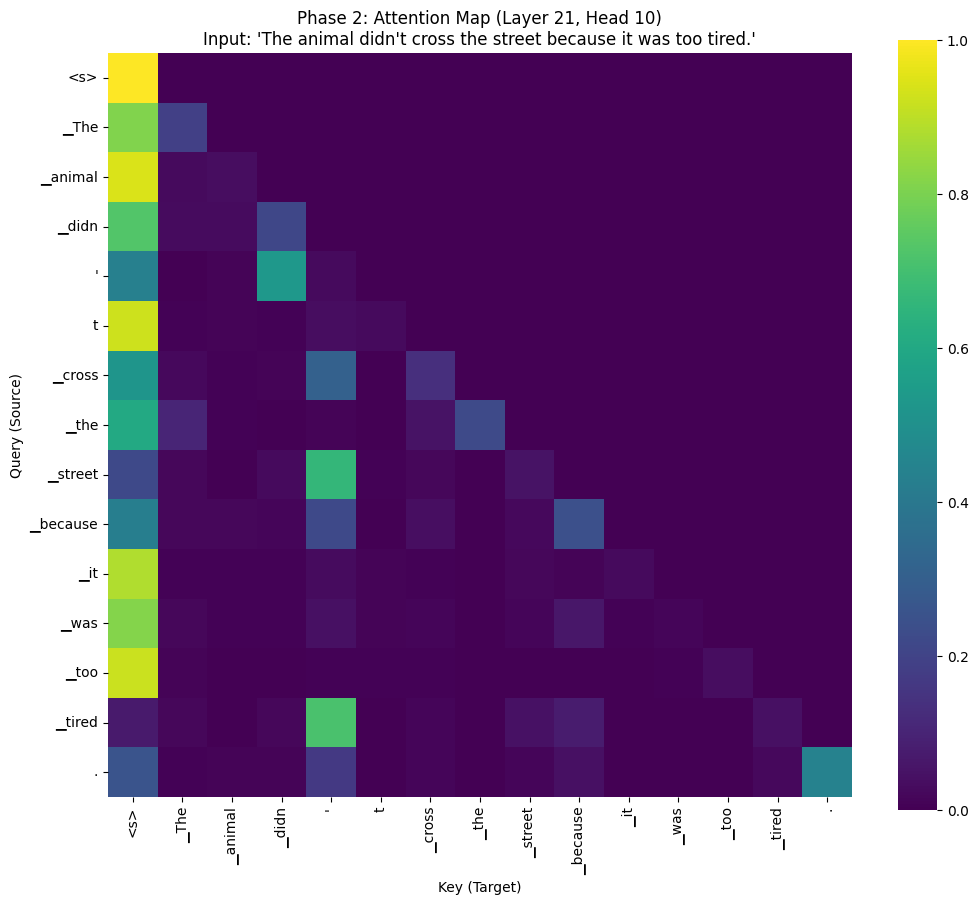

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

# 진행 상황을 강제로 출력하게 설정
sys.stdout.flush()

print("🚀 [1/5] 라이브러리 로딩 중...")

# 0. 결과 폴더 확인
if not os.path.exists('../results'):
    os.makedirs('../results')

# 1. 모델 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 [2/5] 사용 장치 확인됨: {device}")
print("⏳ [3/5] 모델과 토크나이저를 다운로드/로딩 중입니다... (시간이 좀 걸립니다)")

model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
try:
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(model_id, output_attentions=True).to(device)
    print("✅ 모델 로드 완료!")
except Exception as e:
    print(f"❌ 모델 로드 실패: {e}")
    raise e

print("🚀 [4/5] 추론(Inference) 시작...")

# 실험 문장
text = "The animal didn't cross the street because it was too tired."
inputs = tokenizer(text, return_tensors="pt").to(device)
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
clean_tokens = [t.replace(' ', '') for t in tokens]

# 추론
with torch.no_grad():
    outputs = model(**inputs)

print("🚀 [5/5] 어텐션 추출 및 시각화 중...")

# 어텐션 추출
last_layer_attentions = outputs.attentions[-1]
head_idx = 10
attention_matrix = last_layer_attentions[0, head_idx, :, :].cpu().numpy()

# 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(attention_matrix,
            xticklabels=clean_tokens,
            yticklabels=clean_tokens,
            cmap="viridis",
            square=True,
            vmin=0, vmax=1)

plt.title(f"Phase 2: Attention Map (Layer 21, Head {head_idx})\nInput: '{text}'")
plt.xlabel("Key (Target)")
plt.ylabel("Query (Source)")

safe_filename = "winograd_attention"
save_path = f"../results/02_attention_{safe_filename}.png"
plt.savefig(save_path, bbox_inches='tight')
print(f"\n📸 저장 완료: {save_path}")

plt.show()